In [28]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF
from datetime import datetime as dt


warnings.filterwarnings("ignore")
%matplotlib inline

In [81]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [29]:
# Train Dataset
train_df = pd.read_csv("./data/train.csv", parse_dates=True, low_memory=False, index_col='Date')

# Store Data
store_df = pd.read_csv("./data/store.csv", low_memory=False)

# Test Dataset
test_df = pd.read_csv("./data/test.csv", parse_dates=True, low_memory=False, index_col='Date')

# Sample Submission
sample_df = pd.read_csv("./data/sample_submission.csv")


In [30]:
train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [31]:
train_df.shape

(1017209, 8)

In [32]:
train_df.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   Customers      1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


In [34]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [35]:
test_df.head()

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,1,1,4,1.0,1,0,0
2015-09-17,2,3,4,1.0,1,0,0
2015-09-17,3,7,4,1.0,1,0,0
2015-09-17,4,8,4,1.0,1,0,0
2015-09-17,5,9,4,1.0,1,0,0


In [36]:
sample_df.head()

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [71]:
# Data Extraction
train_df['Year'] = train_df.index.year
train_df['Month'] = train_df.index.month
train_df['Day'] = train_df.index.day
train_df['DayName'] = train_df.index.day_name()
train_df['WeekofYr'] = train_df.index.weekofyear
train_df['DayofYr'] = train_df.index.day_of_year
train_df['DayofWk'] = train_df.index.day_of_week
train_df.tail(10)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WkofYr,SalesPerCustomer,DayName,WeekofYr,DayofYr,DayofWk
Date,,,,,,,,,,,,,,,,,
2013-01-01,1106,2,0,0,0,0,a,1,2013,1,1,1,NaN,Tuesday,1,1,1
2013-01-01,1107,2,0,0,0,0,a,1,2013,1,1,1,NaN,Tuesday,1,1,1
2013-01-01,1108,2,0,0,0,0,a,1,2013,1,1,1,NaN,Tuesday,1,1,1
2013-01-01,1109,2,0,0,0,0,a,1,2013,1,1,1,NaN,Tuesday,1,1,1
2013-01-01,1110,2,0,0,0,0,a,1,2013,1,1,1,NaN,Tuesday,1,1,1
2013-01-01,1111,2,0,0,0,0,a,1,2013,1,1,1,NaN,Tuesday,1,1,1
2013-01-01,1112,2,0,0,0,0,a,1,2013,1,1,1,NaN,Tuesday,1,1,1
2013-01-01,1113,2,0,0,0,0,a,1,2013,1,1,1,NaN,Tuesday,1,1,1
2013-01-01,1114,2,0,0,0,0,a,1,2013,1,1,1,NaN,Tuesday,1,1,1


In [38]:
train_df['SalesPerCustomer'] = train_df.Sales/train_df.Customers
train_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WkofYr,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


In [39]:
train_df['SalesPerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalesPerCustomer, dtype: float64

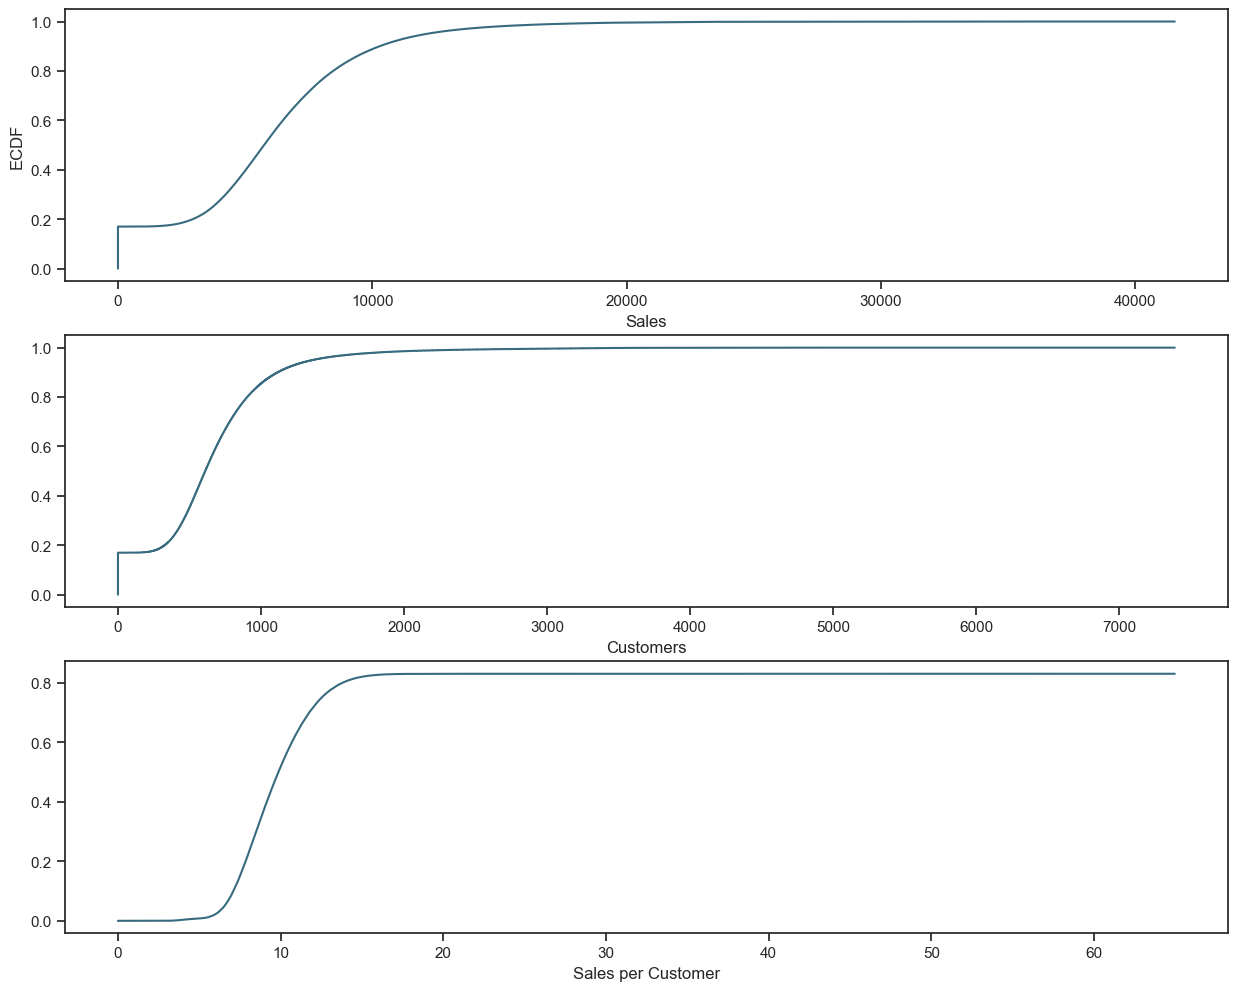

In [47]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (15, 12))

plt.subplot(311)
cdf = ECDF(train_df['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales'); plt.ylabel('ECDF');

# plot second ECDF  
plt.subplot(312)
cdf = ECDF(train_df['Customers'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Customers');

# plot second ECDF  
plt.subplot(313)
cdf = ECDF(train_df['SalesPerCustomer'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('Sales per Customer');

##### About 20% of data has zero amount of sales / customers that we need to deal with and almost 80% of time daily amount of sales was less than 1000

### Missing Values

In [48]:
# closed stores and stores with no sales
train_df[(train_df.Open == 0)&(train_df.Sales == 0)]

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WkofYr,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN


In [49]:
len(train_df[(train_df.Open == 0)&(train_df.Sales == 0)])

172817

In [65]:
print("There are %d closed stores in the training dataset."%len(train_df[train_df.Open == 0]))
print("%f percent of the stores in the training dataset are closed"%(len(train_df[train_df.Open == 0])/len(train_df)*100))

There are 172817 closed stores in the training dataset.
16.989331 percent of the stores in the training dataset are closed


In [63]:
print("Around %f percent of the stores in the training dataset are closed"%(len(train_df[train_df.Open == 0])/len(train_df)*100))

Around 16.989331 percent of the stores in the training dataset are closed


In [51]:
len(train_df[train_df.Sales == 0])

172871

In [69]:
# opened stores with zero sales
zero_sales = train_df[(train_df.Open == 1) & (train_df.Sales == 0)]
print("In total: ", zero_sales.shape)
zero_sales.head()

In total:  (54, 13)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WkofYr,SalesPerCustomer
Date,,,,,,,,,,,,,
2015-05-15,971,5,0,0,1,0,0,1,2015,5,15,20,NaN
2015-03-26,674,4,0,0,1,0,0,0,2015,3,26,13,NaN
2015-02-05,699,4,0,0,1,1,0,0,2015,2,5,6,NaN
2014-10-01,708,3,0,0,1,1,0,0,2014,10,1,40,NaN
2014-09-22,357,1,0,0,1,0,0,0,2014,9,22,39,NaN


In [72]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train_df = train_df[(train_df["Open"] != 0) & (train_df['Sales'] != 0)]

print("In total: ", train_df.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 17)


In [73]:
# additional information about the stores
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [74]:
# missing value
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [75]:
# missing values in competition distance
store_df[pd.isnull(store_df.CompetitionDistance)]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [76]:
# fill NaN with a median value (skewed distribuion)
store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median(), inplace = True)

In [78]:
# no promo = no information about the promo?
_ = store_df[pd.isnull(store_df.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

#### If there's no Promo2 then there's no information about it. We can replace these values by zeros. The same goes for tha variables deducted from the competition

In [79]:
# replace NA's by 0
store_df.fillna(0, inplace = True)

In [82]:
print("Joining train set with an additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
train_store_df = pd.merge(train_df, store_df, how = 'inner', on = 'Store')

print("In total: ", train_store_df.shape)
train_store_df.head()

Joining train set with an additional store information.
In total:  (844338, 26)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WkofYr,SalesPerCustomer,DayName,WeekofYr,DayofYr,DayofWk,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883,Friday,31,212,4,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,30,31,9.194139,Thursday,31,211,3,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,29,31,9.143403,Wednesday,31,210,2,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,28,31,8.948214,Tuesday,31,209,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,27,31,9.970588,Monday,31,208,0,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
